# Import and Cleaning

In [1]:
# adding path to import custom functions
import sys
sys.path.append("/home/artur/code/masters-project/main_project/notebooks/model_creation")

In [2]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter, gmtime, strftime

from functions import remove_high_corr, scale_variables, best_params_grid, calculate_confusion_matrix, plot_roc_auc_curve, bart_auc_scorer, make_label, get_error_and_auc

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedKFold, train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer

from ISLP.bart import BART

import session_info 

In [3]:
data = pd.read_csv("../data/fda_padel_pre_processed_descriptors_no_inputation.csv")
data.head()

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,JGI7,JGI8,JGI9,JGI10,VE1_D,VE2_D,VR1_D,VR2_D,SRW5,XLogP
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,-1.734723e-18,0.0,8.673617e-19,0.0,1.110223e-16,2.775558e-17,3.000000e+06,750000.000000,0.0,-0.646
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,-1.734723e-18,0.0,8.673617e-19,0.0,6.081016e-02,1.216203e-02,1.237595e+01,2.475191,0.0,-0.728
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,-1.734723e-18,0.0,8.673617e-19,0.0,6.081016e-02,1.216203e-02,1.237595e+01,2.475191,0.0,-1.606
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,-1.734723e-18,0.0,8.673617e-19,0.0,0.000000e+00,0.000000e+00,8.452347e+00,2.113087,0.0,0.106
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,-1.734723e-18,0.0,8.673617e-19,0.0,1.110223e-16,2.775558e-17,3.000000e+06,750000.000000,0.0,-0.786


In [4]:
Y = data["oral"]
Y = Y.astype(float)
Y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: oral, dtype: float64

In [5]:
X = data.iloc[:, 14:]
X.head()

,ALogP,ALogp2,AMR,apol,naAromAtom,nB,nN,nO,nS,nP,...,JGI7,JGI8,JGI9,JGI10,VE1_D,VE2_D,VR1_D,VR2_D,SRW5,XLogP
0,-0.4695,0.220430,11.1997,8.393965,0.0,0.0,3.0,0.0,0.0,0.0,...,-1.734723e-18,0.0,8.673617e-19,0.0,1.110223e-16,2.775558e-17,3.000000e+06,750000.000000,0.0,-0.646
1,-1.0852,1.177659,15.4305,9.557965,0.0,0.0,1.0,2.0,0.0,0.0,...,-1.734723e-18,0.0,8.673617e-19,0.0,6.081016e-02,1.216203e-02,1.237595e+01,2.475191,0.0,-0.728
2,-1.0880,1.183744,12.5072,8.231172,0.0,0.0,2.0,2.0,0.0,0.0,...,-1.734723e-18,0.0,8.673617e-19,0.0,6.081016e-02,1.216203e-02,1.237595e+01,2.475191,0.0,-1.606
3,-0.2157,0.046526,22.3381,12.187551,0.0,0.0,1.0,0.0,1.0,0.0,...,-1.734723e-18,0.0,8.673617e-19,0.0,0.000000e+00,0.000000e+00,8.452347e+00,2.113087,0.0,0.106
4,-0.5895,0.347510,11.3934,11.222758,0.0,0.0,0.0,1.0,1.0,0.0,...,-1.734723e-18,0.0,8.673617e-19,0.0,1.110223e-16,2.775558e-17,3.000000e+06,750000.000000,0.0,-0.786


In [6]:
# separate train an test datasets

np.random.seed(750059)
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)

# Constant Variables

In [7]:
DESCRIPTOR_TYPE = "padel_no_inputation"

# Scaling datsets

The datasets are being scaled to be used, when necessary, scaled

In [8]:
# TRAIN

x_train_scaled = scale_variables(x_train)

# adding constant
x_train_scaled = sm.add_constant(x_train_scaled)

x_train_scaled.head()

,const,ALogP,ALogp2,AMR,apol,naAromAtom,nB,nN,nO,nS,...,JGI7,JGI8,JGI9,JGI10,VE1_D,VE2_D,VR1_D,VR2_D,SRW5,XLogP
0,1.0,-0.795767,0.070400,0.383925,0.367736,-0.413303,-0.059549,-0.198148,0.414924,-0.462652,...,-0.047648,0.043547,0.049401,0.587233,0.453879,0.238034,-0.148114,-0.159056,1.196591,0.642002
1,1.0,0.891981,-0.234984,-1.006690,-0.478179,1.239590,-0.059549,1.192163,-0.851098,-0.462652,...,-0.647510,0.482174,-0.044782,1.529566,-0.971325,-1.061341,-0.148112,-0.159022,0.733189,-0.312795
2,1.0,0.121050,-0.274724,-0.856331,-0.905746,0.037486,-0.059549,-0.198148,-0.534592,1.161795,...,0.213676,0.899232,-1.581658,-1.269317,-0.556677,-0.263685,-0.148128,-0.158932,0.733189,-0.524582
3,1.0,0.876318,-0.238791,0.634921,1.035941,1.239590,-0.059549,-0.198148,0.414924,1.161795,...,0.207647,-0.166018,-0.073261,0.468766,-0.775086,-0.970117,-0.147725,-0.158893,0.733189,1.498970
4,1.0,1.629929,0.085415,-0.897213,-1.649783,-1.314881,-0.059549,-1.125022,-0.851098,-0.462652,...,-2.334226,-1.939082,-1.581658,-1.269317,-0.933253,-0.640012,-0.148317,-0.159122,-0.985250,-0.411676


In [9]:
# TEST

x_test_scaled = scale_variables(x_test)

# adding constant
x_test_scaled = sm.add_constant(x_test_scaled)

x_test_scaled.head()

,const,ALogP,ALogp2,AMR,apol,naAromAtom,nB,nN,nO,nS,...,JGI7,JGI8,JGI9,JGI10,VE1_D,VE2_D,VR1_D,VR2_D,SRW5,XLogP
0,1.0,0.614036,-0.263678,-0.778835,-0.894890,-0.380504,-0.046078,-0.662624,-0.875659,-0.476565,...,1.945897,-1.634677,-1.386281,-1.126695,0.660575,2.253822,-0.141332,-0.146043,-0.976314,-0.154760
1,1.0,0.344185,-0.278075,-0.602394,-1.339201,-1.351302,-0.046078,-0.662624,-0.512468,1.153426,...,-2.048910,-1.634677,-1.386281,-1.126695,-0.573006,0.291472,-0.141345,-0.146026,-0.976314,-1.711787
2,1.0,-0.220189,-0.192969,1.076198,0.438685,-0.542303,-0.046078,0.930373,2.393058,1.153426,...,0.447752,0.484197,0.482099,0.582309,-0.651976,-0.874624,-0.140700,-0.145802,0.744698,-0.862467
3,1.0,-0.898544,0.115626,0.871281,0.248744,-1.351302,-0.046078,-1.193622,0.577104,-0.476565,...,-0.436211,-0.087362,0.572708,0.457410,-0.211127,-0.294171,-0.140660,-0.145644,0.744698,-0.040683
4,1.0,0.713909,-0.249313,-0.801084,-0.487992,0.590295,-0.046078,-0.131625,-1.238850,-0.476565,...,-0.351117,0.563974,-1.386281,-1.126695,0.121043,0.438258,-0.141218,-0.145972,-0.976314,0.655581


# Logistic Regression

## Model Constant Variables

In [10]:
model_name_title = "Logistic Regression"
model_name_path = "logistic_regression"

## Cross Validation

Here, I will use the best_params_grid function, which looks for the best hyperparameters, using CV. There are no hyperparameters in Logistic Regression, so this function will only perform CV.

In [11]:
model_params_lr = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {}
    }
}

In [12]:
gs_result_lr, gs_result_lr_full = best_params_grid(x_train, y_train, model_params_lr)

Starting Grid Search for Logistic Regression: 13:11


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Finished Grid Search for Logistic Regression: 13:11
Tempo de execução:  0.1 minutos


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

In [13]:
gs_result_lr

,model,best_score,best_params
0,Logistic Regression,0.489896,{}


## Calculating Logistic Regression in R

## Saving Datasets to use in R

The logistic regression calculation was presenting problems in Python, so it will be performed in R, in a separate notebook, saved in the folder `logistic_regression`. Here, I will save the training and test datasets, to use them in R.

In [14]:
# reseting indices
x_train_scaled = x_train_scaled.reset_index()
x_test_scaled = x_test_scaled.reset_index()

y_train = y_train.reset_index()
y_test = y_test.reset_index()

In [15]:
# joining x and y training and test datasets
train = pd.concat([x_train_scaled, y_train], axis=1).drop(["index"], axis=1)
test = pd.concat([x_test_scaled, y_test], axis=1).drop(["index"], axis=1)

In [16]:
# saving datasets
train.to_csv(f"logistic_regression/data/train_{DESCRIPTOR_TYPE}.csv")
test.to_csv(f"logistic_regression/data/test_{DESCRIPTOR_TYPE}.csv")

## Importing results from R

In [19]:
results_log_reg_df = pd.read_csv(f"logistic_regression/data/lr_coefficients_{DESCRIPTOR_TYPE}.csv")
results_log_reg_df.head()

,Unnamed: 0,Estimate,Std. Error,z value,Pr(>|z|)
0,(Intercept),6.814866e+14,4.404821e+06,1.547138e+08,0
1,X,-2.520245e+11,5.696418e+03,-4.424263e+07,0
2,ALogP,2.991140e+14,1.424924e+07,2.099158e+07,0
3,ALogp2,3.084777e+14,9.947165e+06,3.101161e+07,0
4,AMR,4.316871e+14,9.780125e+07,4.413922e+06,0


In [20]:
# y predict in test set
y_predict_lr_prob = pd.read_csv(f"logistic_regression/data/y_predict_proba_test_{DESCRIPTOR_TYPE}.csv")
y_predict_lr_prob = y_predict_lr_prob["x"]
y_predict_lr_prob.head()

0    2.220446e-16
1    1.000000e+00
2    1.000000e+00
3    2.220446e-16
4    2.220446e-16
Name: x, dtype: float64

In [21]:
# here I use the make_label function to transform the probabilities into labels, using 0.5 as a cutoff

make_label_v = np.vectorize(make_label)
y_predict_labels_lr = make_label_v(y_predict_lr_prob)

In [22]:
# y predict in training set
y_predict_lr_prob_train = pd.read_csv(f"logistic_regression/data/y_predict_proba_train_{DESCRIPTOR_TYPE}.csv")
y_predict_lr_prob_train = y_predict_lr_prob_train["x"]
y_predict_lr_prob_train.head()

0    1.000000e+00
1    1.000000e+00
2    1.000000e+00
3    1.000000e+00
4    2.220446e-16
Name: x, dtype: float64

## Get Training Error and AUC

In [23]:
mis_rate_lr_train, auc_lr_train = get_error_and_auc(
    model=y_predict_lr_prob_train, 
    x=x_train_scaled,
    y_true=y_train["oral"],
    transform_prob_into_label=True,
    log_reg=True
)

Training Misclassification Rate: 0.1760
Training AUC: 0.8135


## Test Error

In [24]:
mis_rate_lr, disp = calculate_confusion_matrix(
    y_test=y_test["oral"], 
    y_pred=y_predict_labels_lr,
)

Misclassification rate: 0.5297


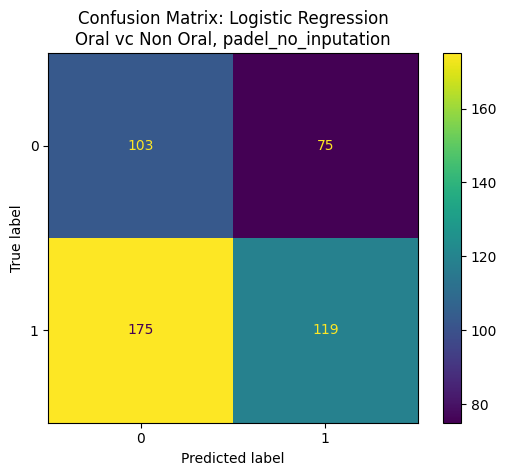

In [25]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

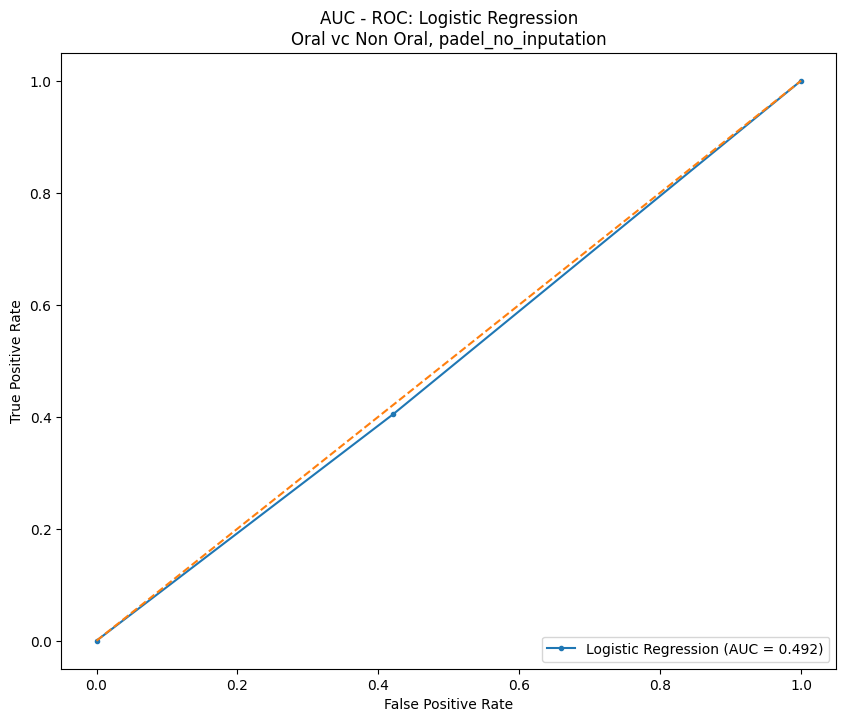

In [26]:
auc_lr = plot_roc_auc_curve(
    y_test=y_test["oral"],
    y_pred=y_predict_lr_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

In [27]:
# converting results summary to pandas dataframe
results_log_reg_df = results_log_reg_df.rename(columns={"Unnamed: 0": "descriptor_name"})
results_log_reg_df = results_log_reg_df.set_index(results_log_reg_df["descriptor_name"]).drop("descriptor_name", axis=1)
results_log_reg_df.shape
results_log_reg_df.head()

,Estimate,Std. Error,z value,Pr(>|z|)
descriptor_name,,,,
(Intercept),6.814866e+14,4.404821e+06,1.547138e+08,0
X,-2.520245e+11,5.696418e+03,-4.424263e+07,0
ALogP,2.991140e+14,1.424924e+07,2.099158e+07,0
ALogp2,3.084777e+14,9.947165e+06,3.101161e+07,0
AMR,4.316871e+14,9.780125e+07,4.413922e+06,0


In [28]:
important_features_lr = results_log_reg_df[results_log_reg_df["Pr(>|z|)"] < 0.05]
important_features_lr = important_features_lr.reindex(important_features_lr['Estimate'].abs().sort_values(ascending=False).index)
print(important_features_lr.shape)
important_features_lr

(576, 4)


,Estimate,Std. Error,z value,Pr(>|z|)
descriptor_name,,,,
ETA_AlphaP,1.130231e+19,4.426069e+11,2.553577e+07,0
ETA_dAlpha_B,7.991552e+18,3.130888e+11,2.552487e+07,0
ETA_dAlpha_A,-6.686970e+18,2.620480e+11,-2.551811e+07,0
ETA_Epsilon_2,-7.245354e+17,4.346680e+10,-1.666871e+07,0
ETA_Epsilon_5,6.160916e+17,3.731833e+10,1.650909e+07,0
...,...,...,...,...
minsssCH,-7.521411e+12,7.287092e+06,-1.032155e+06,0
ATSC6s,-4.161077e+12,1.491124e+07,-2.790563e+05,0
MDEN.11,4.101768e+12,7.794531e+06,5.262367e+05,0


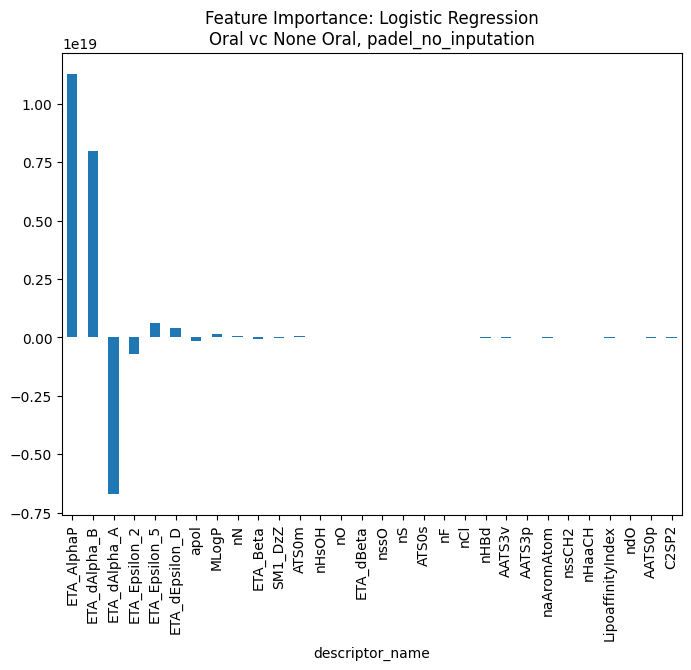

In [29]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

important_features_lr.iloc[:30,0].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

## Saving Results

In [30]:
# creating dataset to store final results from each model
final_results = pd.DataFrame(
    columns=[
        "model_name", 
        "cv_test_auc", 
        "training_mis_rate", 
        "test_mis_rate", 
        "training_auc",
        "test_auc"
    ]
)

In [31]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_lr["best_score"][0],
    mis_rate_lr_train,
    mis_rate_lr,
    auc_lr_train,
    auc_lr
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.489896,0.175972,0.529661,0.813456,0.491707


In [32]:
important_features_lr.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# TREES

# Decision Tree

## Model Constant Variables

In [27]:
model_name_title = "Decision Tree"
model_name_path = "decision_tree"

## Hyperparameter Fine Tuning

In [28]:
model_params = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [1, 5, 10, 20, 50, 100, 150],
            'ccp_alpha': [0, 0.0001, 0.001, 0.1, 0.5, 1]
        }
    }
}

In [29]:
gs_result_dt, gs_result_dt_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for Decision Tree: 08:49
Finished Grid Search for Decision Tree: 09:14
Tempo de execução:  25.7 minutos


In [30]:
gs_result_dt

,model,best_score,best_params
0,Decision Tree,0.635919,"{'ccp_alpha': 0.0001, 'criterion': 'entropy', ..."


## Fitting Tree

In [31]:
decision_tree_params = gs_result_dt.iloc[0,2]
decision_tree_params

{'ccp_alpha': 0.0001, 'criterion': 'entropy', 'max_depth': 5}

In [32]:
decision_tree = DecisionTreeClassifier(**decision_tree_params).fit(x_train, y_train)

## Get Training Error and AUC

In [33]:
mis_rate_dt_train, auc_dt_train = get_error_and_auc(
    model=decision_tree, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.2784
Training AUC: 0.6626


## Make Predictions

In [34]:
y_predict_dt_label = decision_tree.predict(x_test)
y_predict_dt_prob = decision_tree.predict_proba(x_test)[:, 1]

## Test Error

In [35]:
mis_rate_dt, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_dt_label,
)

Misclassification rate: 0.3686


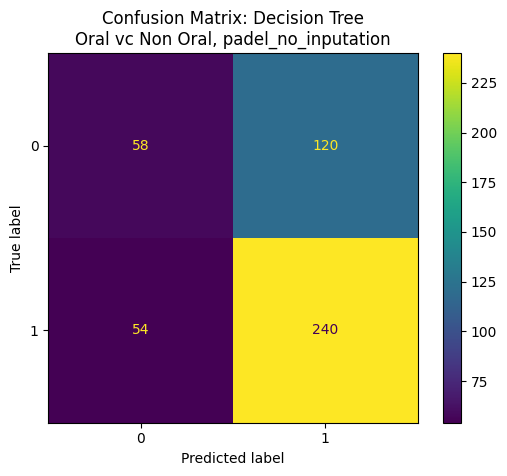

In [36]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

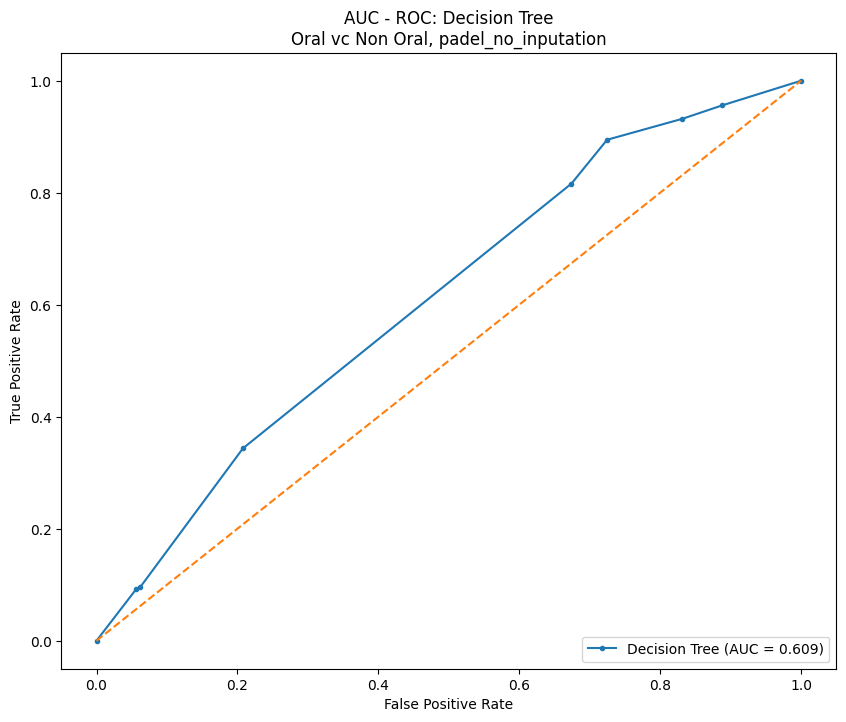

In [37]:
auc_dt = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_dt_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Visualizing the Tree

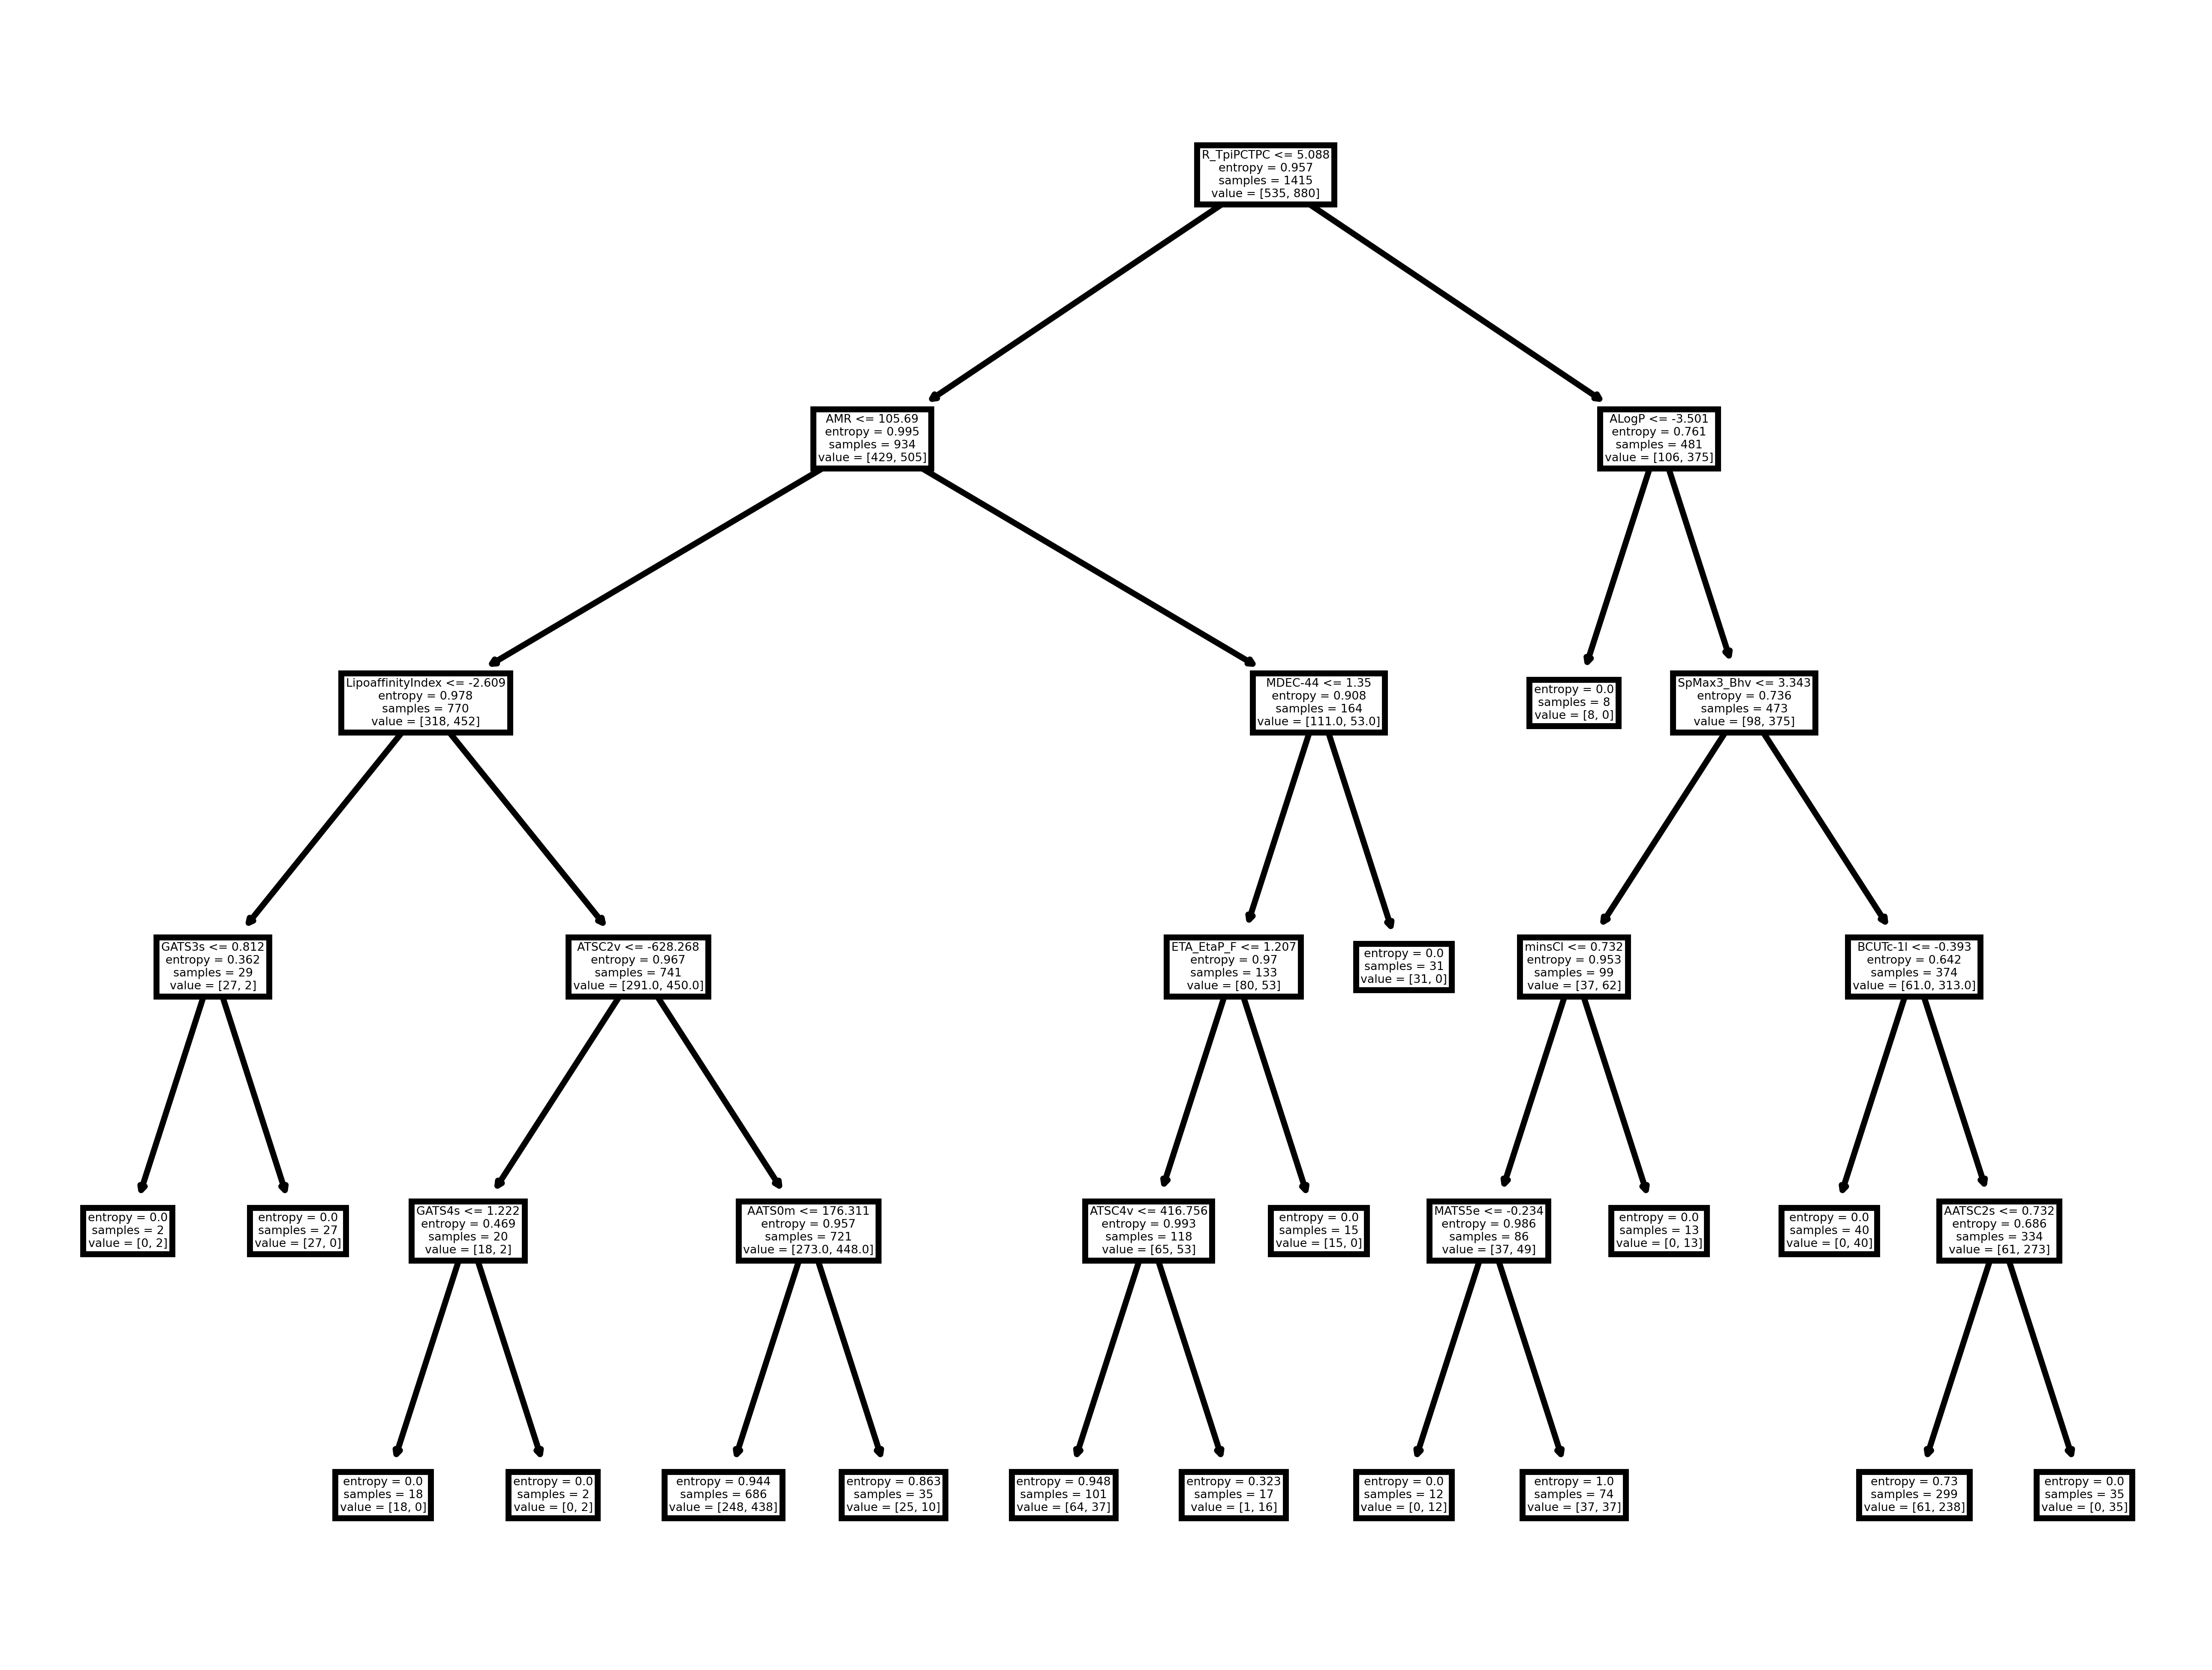

In [38]:
fig, ax = plt.subplots()
fig.dpi = 1000

tree.plot_tree(decision_tree, ax=ax, feature_names=list(x_train.columns))
plt.show()

fig.savefig(f"imgs/decision_tree_{DESCRIPTOR_TYPE}", dpi=1000)

## Feature Importance

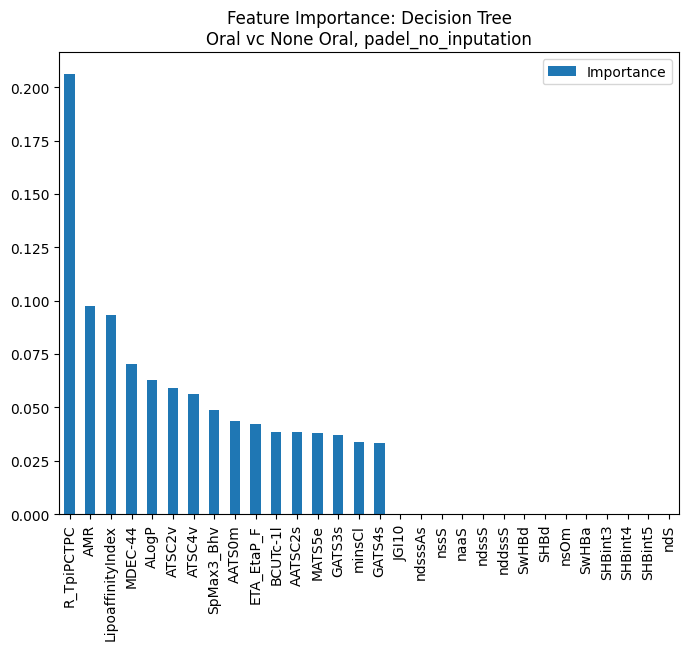

In [39]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(decision_tree.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [40]:
important_features_dt = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_dt

,Importance
GATS4s,0.033202
minsCl,0.034010
GATS3s,0.037165
MATS5e,0.038187
AATSC2s,0.038316
BCUTc-1l,0.038683
ETA_EtaP_F,0.042124
AATS0m,0.043552
SpMax3_Bhv,0.048773
ATSC4v,0.056288


## Saving Results

In [41]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_dt["best_score"][0],
    mis_rate_dt_train,
    mis_rate_dt,
    auc_dt_train,
    auc_dt
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.489896,0.173145,0.377119,0.801073,0.632997
1,Decision Tree,0.635919,0.278445,0.368644,0.662553,0.609207


In [42]:
important_features_dt.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Random Forest and Bagging

Bagging is just Random Forest, in which max_features is equal to the total number of features. Therefore, bagging will be done in the RF algorithm, and compared to RF.

## Model Constant Variables

In [43]:
model_name_title = "Random Forest"
model_name_path = "random_forest"

## Hyperparameter Fine Tuning

In [44]:
model_params = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 500, 1000], # number of trees
            'max_depth': [10, 50, 100],
            'max_features': ["sqrt", "log2"], # m, number of features considered in split. When it is equal to all predictor of dataset, it is bagging
            'ccp_alpha': [0, 0.1, 0.5]
        }
    }
}

In [45]:
gs_result_rf, gs_result_rf_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for Random Forest: 09:14
Finished Grid Search for Random Forest: 11:17
Tempo de execução:  122.8 minutos


In [46]:
gs_result_rf

,model,best_score,best_params
0,Random Forest,0.703663,"{'ccp_alpha': 0, 'max_depth': 100, 'max_featur..."


## Fitting Model

In [47]:
random_forest_params = gs_result_rf.iloc[0,2]
random_forest_params

{'ccp_alpha': 0, 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 500}

In [48]:
random_forest = RandomForestClassifier(**random_forest_params).fit(x_train, y_train)

## Get Training Error and AUC

In [49]:
mis_rate_rf_train, auc_rf_train = get_error_and_auc(
    model=random_forest, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.0028
Training AUC: 0.9963


## Make Predictions

In [50]:
y_predict_rf_label = random_forest.predict(x_test)
y_predict_rf_prob = random_forest.predict_proba(x_test)[:, 1]

## Test Error

In [51]:
mis_rate_rf, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_rf_label,
)

Misclassification rate: 0.2818


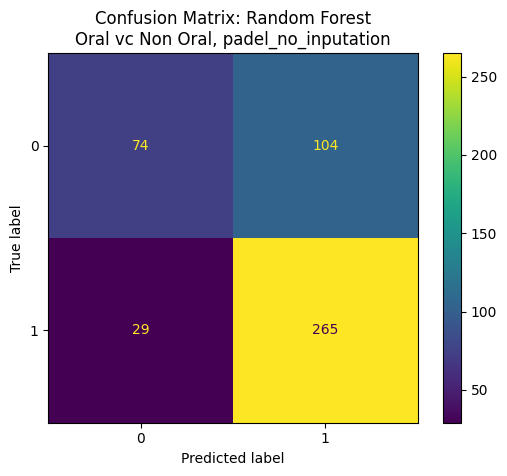

In [52]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

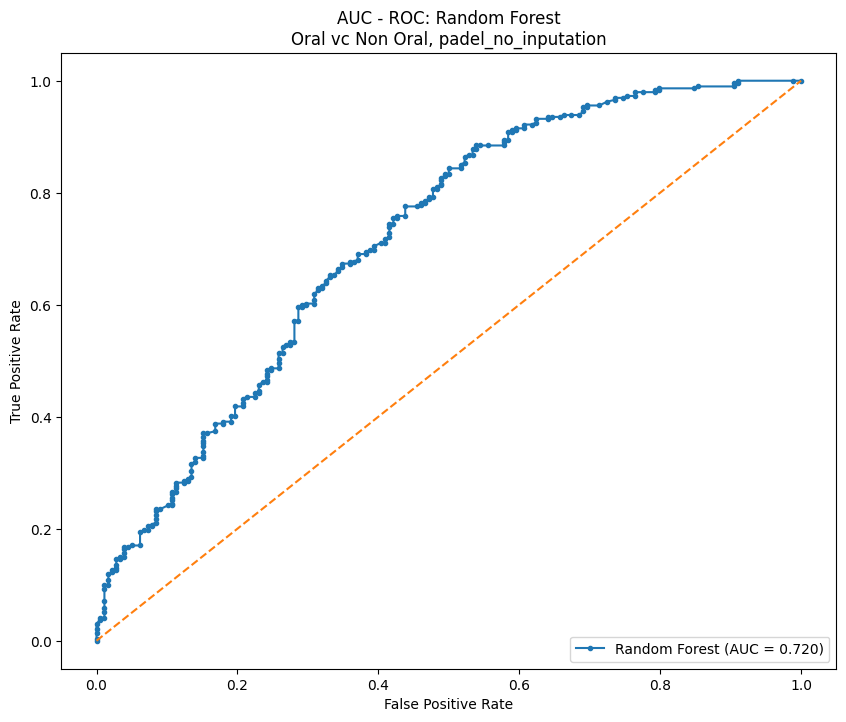

In [53]:
auc_rf = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_rf_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

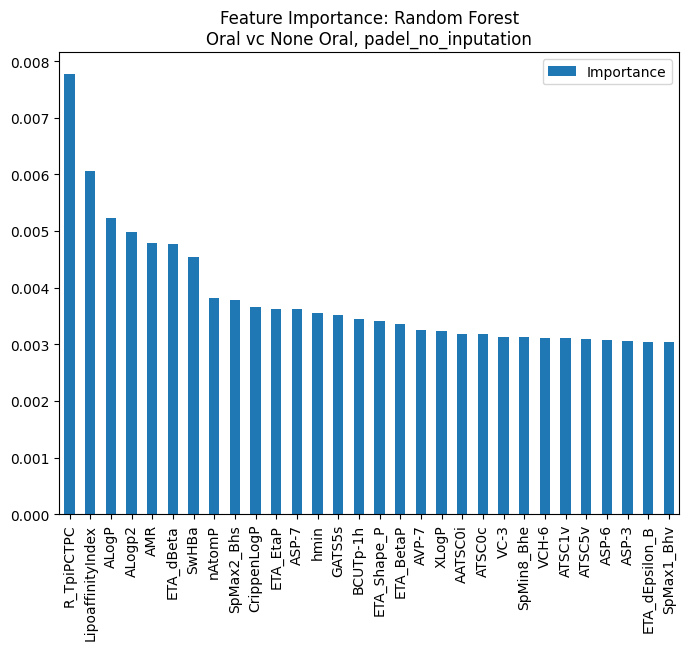

In [54]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(random_forest.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [55]:
important_features_rf = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_rf

,Importance
SHsSH,0.000006
SsI,0.000012
nG12Ring,0.000012
n3HeteroRing,0.000017
maxsI,0.000019
...,...
AMR,0.004794
ALogp2,0.004990
ALogP,0.005236
LipoaffinityIndex,0.006059


## Saving Results

In [56]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_rf["best_score"][0],
    mis_rate_rf_train,
    mis_rate_rf,
    auc_rf_train,
    auc_rf
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.489896,0.173145,0.377119,0.801073,0.632997
1,Decision Tree,0.635919,0.278445,0.368644,0.662553,0.609207
2,Random Forest,0.703663,0.002827,0.281780,0.996262,0.719827


In [57]:
important_features_rf.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Boosting

## Model Constant Variables

In [58]:
model_name_title = "Gradiant Boosting"
model_name_path = "boosting"

## Hyperparameter Fine Tuning

In [59]:
model_params = {
    'Boosting': {
            'model': GradientBoostingClassifier(),
            'params': {
                'n_estimators' : [100, 500], # number of trees
                'learning_rate': [0.01, 0.1], # alfa
                'max_depth': [20],
        }
    }
}

In [60]:
gs_result_boo, gs_result_boo_full = best_params_grid(x_train_scaled, y_train, model_params)

Starting Grid Search for Boosting: 11:17
Finished Grid Search for Boosting: 15:45
Tempo de execução:  267.3 minutos


In [61]:
gs_result_boo

,model,best_score,best_params
0,Boosting,0.662135,"{'learning_rate': 0.1, 'max_depth': 20, 'n_est..."


## Fitting Model

In [62]:
boosting_params = gs_result_boo.iloc[0,2]
boosting_params

{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 500}

In [63]:
boosting = GradientBoostingClassifier(**boosting_params).fit(x_train, y_train)

## Get Training Error and AUC

In [64]:
mis_rate_boo_train, auc_boo_train = get_error_and_auc(
    model=boosting, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.0028
Training AUC: 0.9966


## Make Prediction

In [65]:
y_predict_boo_label = boosting.predict(x_test)
y_predict_boo_prob = boosting.predict_proba(x_test)[:, 1]

## Test Error

In [66]:
mis_rate_boo, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_boo_label,
)

Misclassification rate: 0.3665


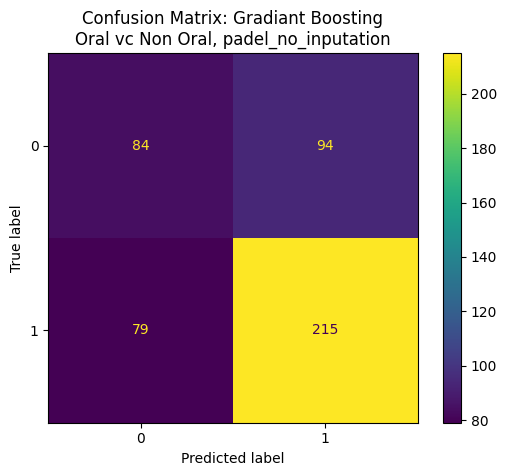

In [67]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

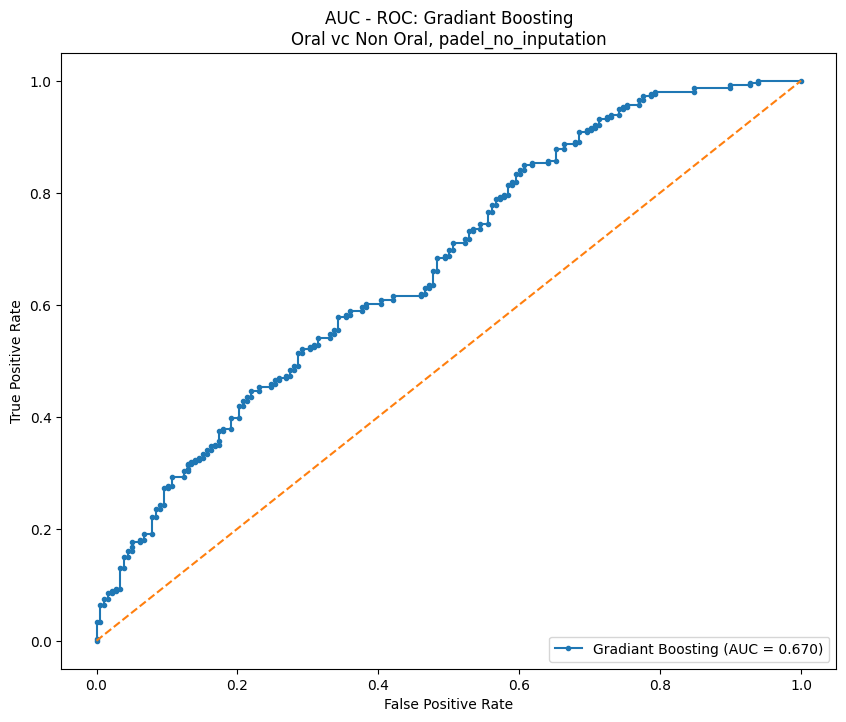

In [68]:
auc_boo = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_boo_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

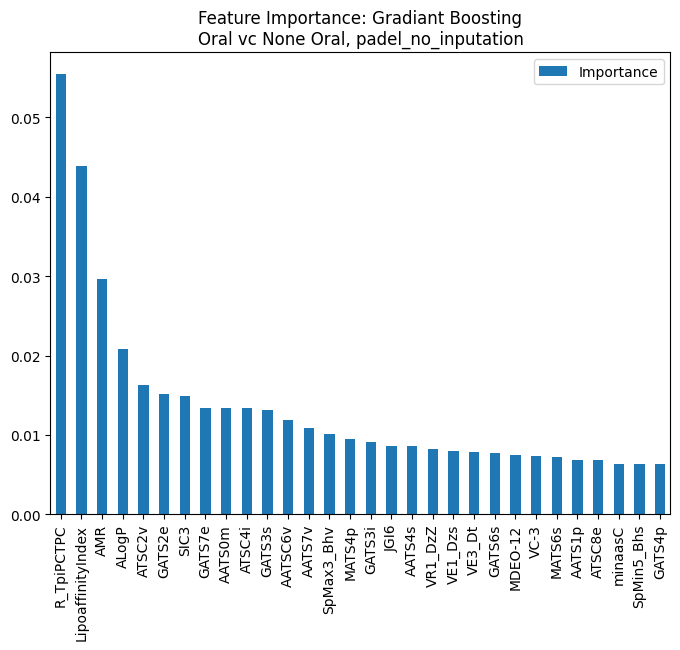

In [69]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(boosting.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [70]:
important_features_boo = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_boo

,Importance
SHsSH,5.204186e-18
nI,3.175798e-17
n3HeteroRing,5.573080e-15
n4Ring,1.307103e-14
nF11Ring,4.035341e-14
...,...
ATSC2v,1.628548e-02
ALogP,2.078790e-02
AMR,2.970467e-02
LipoaffinityIndex,4.390034e-02


## Saving Results

In [71]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_boo["best_score"][0],
    mis_rate_boo_train,
    mis_rate_boo,
    auc_boo_train,
    auc_boo
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.489896,0.173145,0.377119,0.801073,0.632997
1,Decision Tree,0.635919,0.278445,0.368644,0.662553,0.609207
2,Random Forest,0.703663,0.002827,0.281780,0.996262,0.719827
3,Gradiant Boosting,0.662135,0.002827,0.366525,0.996628,0.670488


In [72]:
important_features_boo.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# BART

## Model Constant Variables

In [73]:
model_name_title = "BART"
model_name_path = "bart"

## Hyperparameter Fine Tuning

In [74]:
# transforming x train and test as arrays for BART procedure

x_train_bart = np.asarray(x_train)
x_test_bart = np.asarray(x_test)

In [75]:
model_params = {
    'BART': {
        'model': BART(),
        'params': {
            'num_trees': [100, 500, 1000],
            'max_stages': [100, 500, 800, 1000], # B, number of iterations
            'burnin': [5, 10, 20]
        }
    }
}

For BART, the auc present in the best_params_grid need to recieve the y_predicted in labels, but this BART algorithm does it in probabilities. Because of this, I need to use a custom scorer, that first transforms the prediction to labels.

In [76]:
score = make_scorer(bart_auc_scorer, greater_is_better=True)

gs_result_bart, gs_result_bart_full = best_params_grid(x_train_bart, y_train, model_params, scoring=score)

Starting Grid Search for BART: 15:50
Finished Grid Search for BART: 20:07
Tempo de execução:  257.3 minutos


In [77]:
gs_result_bart

,model,best_score,best_params
0,BART,0.601654,"{'burnin': 20, 'max_stages': 500, 'num_trees':..."


# Fitting Model

In [78]:
bart_params = gs_result_bart.iloc[0,2]
bart_params

{'burnin': 20, 'max_stages': 500, 'num_trees': 500}

In [79]:
bart = BART(**bart_params)
bart.fit(x_train_bart, y_train)

BART(burnin=20, max_stages=500, num_trees=500)

## Get Training Error and AUC

In [80]:
mis_rate_bart_train, auc_bart_train = get_error_and_auc(
    model=bart, 
    x=x_train_bart,
    y_true=y_train,
    transform_prob_into_label=True
)

Training Misclassification Rate: 0.2700
Training AUC: 0.6598


## Make Prediction

In [81]:
# the bart algorithm predicts as probabilities
y_predict_bart_prob = bart.predict(x_test_bart)

In [82]:
# here I use the make_label function to transform the probabilities into labels, using 0.5 as a cutoff

y_predict_bart_label = make_label_v(y_predict_bart_prob)

## Test Error

In [83]:
mis_rate_bart, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_bart_label,
)

Misclassification rate: 0.3305


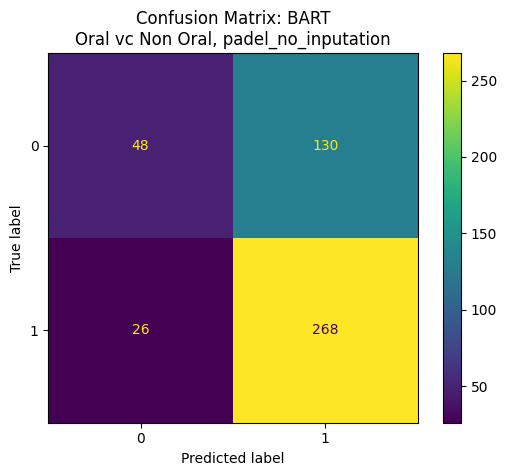

In [84]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

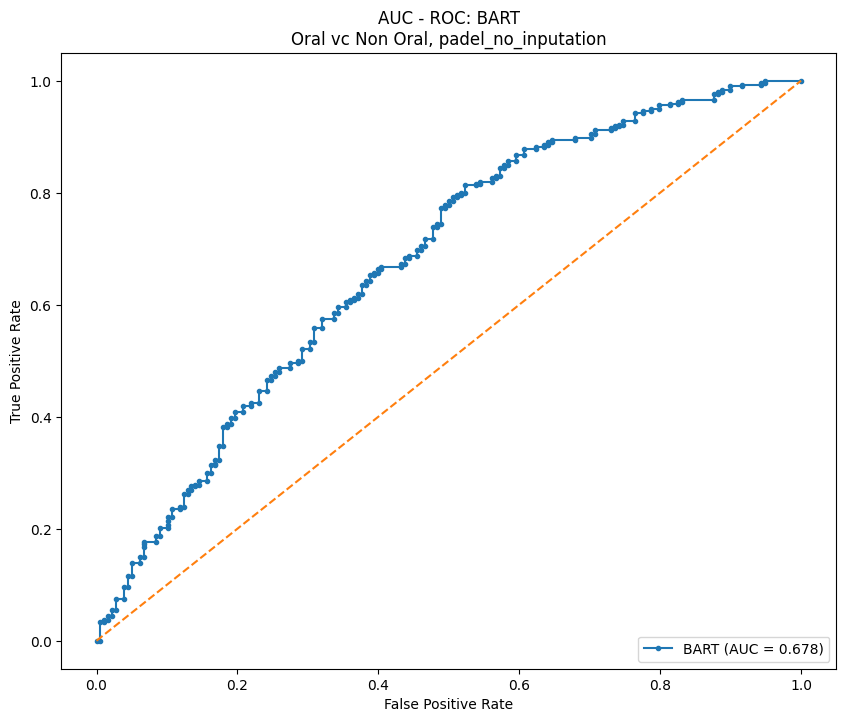

In [85]:
auc_bart = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_bart_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

We can check how many times each variable appeared in the collection
of trees. This gives a summary similar to the variable importance plot for
boosting and random forests.

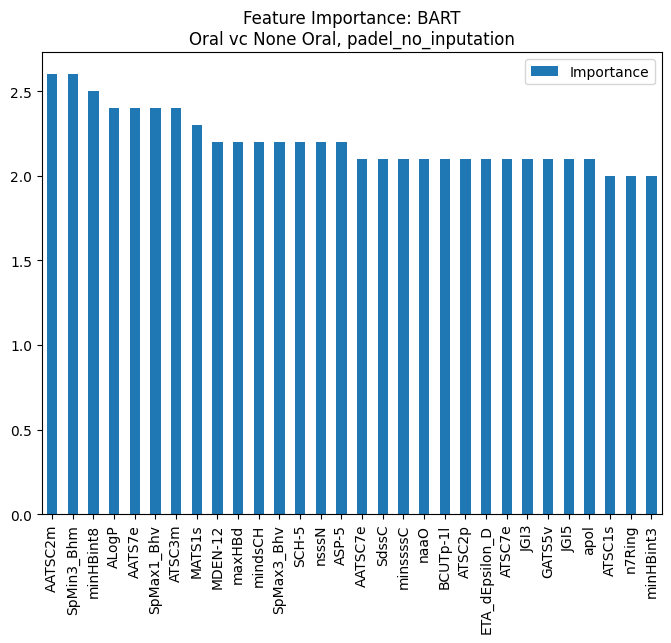

In [86]:
# Print the feature importances
fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(columns=["Importance"])
feat_importances["Importance"] = pd.Series(bart.variable_inclusion_.mean(0),index=X.columns).sort_values(ascending=False)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)


In [87]:
important_features_bart = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_bart

,Importance
ATSC7c,0.1
AATSC4s,0.2
AATS4v,0.3
nF8Ring,0.3
MATS3e,0.4
...,...
AATS7e,2.4
ALogP,2.4
minHBint8,2.5
SpMin3_Bhm,2.6


## Saving Results

In [88]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_bart["best_score"][0],
    mis_rate_bart_train,
    mis_rate_bart,
    auc_bart_train,
    auc_bart
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.489896,0.173145,0.377119,0.801073,0.632997
1,Decision Tree,0.635919,0.278445,0.368644,0.662553,0.609207
2,Random Forest,0.703663,0.002827,0.281780,0.996262,0.719827
3,Gradiant Boosting,0.662135,0.002827,0.366525,0.996628,0.670488
4,BART,0.601654,0.269965,0.330508,0.659845,0.677597


In [89]:
important_features_bart.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# SVM

## Model Constant Variables

In [90]:
model_name_title = "SVM"
model_name_path = "svm"

## Hyperparameter Fine Tuning

In [91]:
scale = 1 / (x_train.shape[1] * x_train.var().mean())

model_params = {
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 0.3, 0.5, 0.8, 1.0, 2, 5, 10],
            'kernel': ['rbf', 'sigmoid'],
            'gamma': ['auto', scale, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10]
        }
    }
}

In [92]:
gs_result_svm, gs_result_svm_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for SVM: 20:08
Finished Grid Search for SVM: 20:36
Tempo de execução:  28.8 minutos


## Fitting Model

In [93]:
svm_params = gs_result_svm.iloc[0,2]
svm_params

{'C': 10, 'gamma': 1.6034713050688962e-13, 'kernel': 'rbf'}

In [94]:
svm = SVC(**svm_params, probability=True).fit(x_train, y_train)

## Get Training Error and AUC

In [95]:
mis_rate_svm_train, auc_svm_train = get_error_and_auc(
    model=svm, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.3654
Training AUC: 0.5194


## Make Prediction

In [96]:
y_predict_svm_label = svm.predict(x_test)
y_predict_svm_prob = svm.predict_proba(x_test)[:, 1]

## Test Error

In [97]:
mis_rate_svm, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_svm_label,
)

Misclassification rate: 0.3835


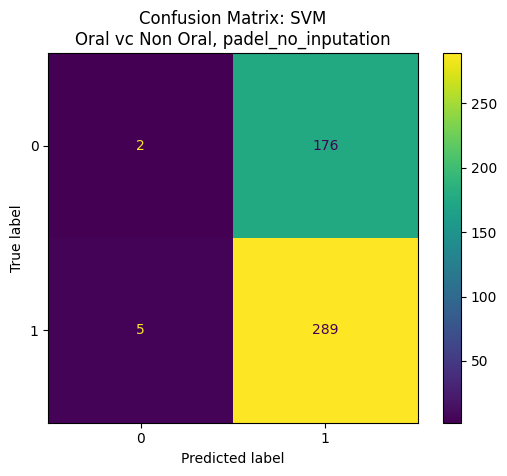

In [98]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

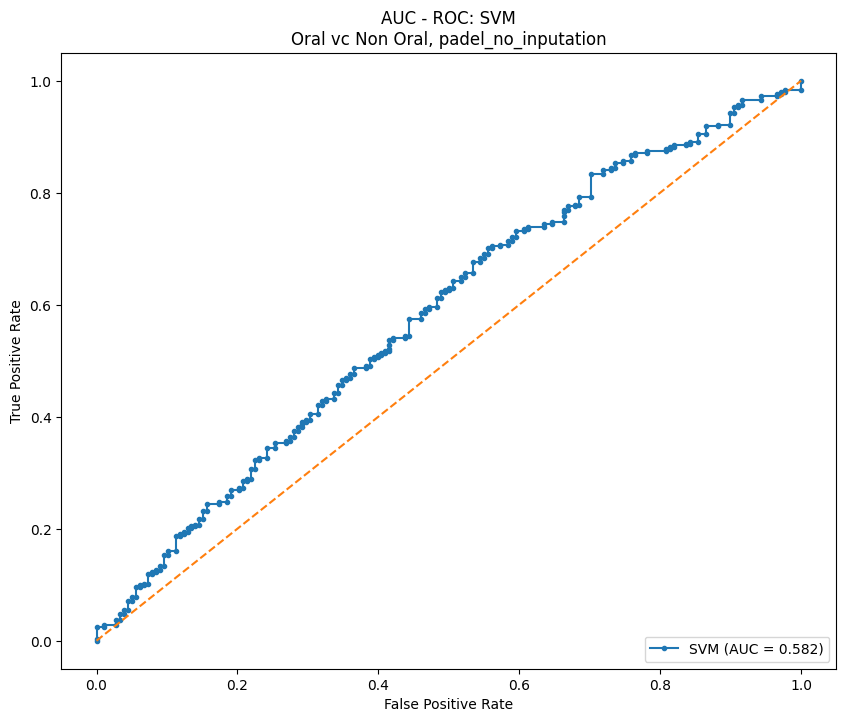

In [99]:
auc_svm = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_svm_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Saving Results

In [100]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_svm["best_score"][0],
    mis_rate_svm_train,
    mis_rate_svm,
    auc_svm_train,
    auc_svm
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.489896,0.173145,0.377119,0.801073,0.632997
1,Decision Tree,0.635919,0.278445,0.368644,0.662553,0.609207
2,Random Forest,0.703663,0.002827,0.281780,0.996262,0.719827
3,Gradiant Boosting,0.662135,0.002827,0.366525,0.996628,0.670488
4,BART,0.601654,0.269965,0.330508,0.659845,0.677597
5,SVM,0.549592,0.365371,0.383475,0.519387,0.581843


# Saving Final Datasets

In [101]:
# saving final_results dataset
final_results.to_csv(f"final_results/models_results_{DESCRIPTOR_TYPE}.csv", index=False)

In [102]:
session_info.show()